# 5
## 5.3
### 5.3.1

In [1]:
# List 5-16

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

W0812 16:57:06.414746 140400149782656 deprecation.py:506] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### データ拡張を行わない高速な特徴抽出

In [4]:
# List 5-17
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/takao/Documents/dev/jupyter/5-cat_and_dog_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if(i * batch_size >= sample_count):
            break;
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [7]:
# List 5-18

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

W0812 17:23:20.681924 140400149782656 deprecation.py:323] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 415us/sample - loss: 0.5670 - acc: 0.6970 - val_loss: 0.4234 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 264us/sample - loss: 0.4111 - acc: 0.8270 - val_loss: 0.3492 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 1s 301us/sample - loss: 0.3447 - acc: 0.8585 - val_loss: 0.3187 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 1s 276us/sample - loss: 0.3046 - acc: 0.8765 - val_loss: 0.2918 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s 303us/sample - loss: 0.2823 - acc: 0.8860 - val_loss: 0.2822 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 278us/sample - loss: 0.2545 - acc: 0.9010 - val_loss: 0.2700 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 270us/sample - loss: 0.2468 - acc: 0.9055 - val_loss: 0.2673 - va

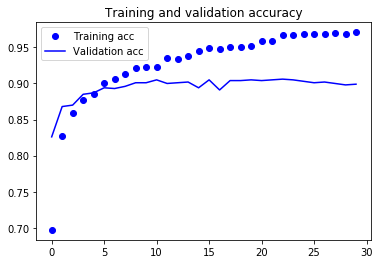

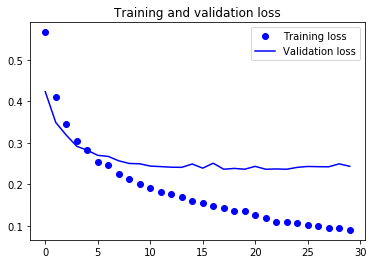

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### データ拡張を行う特徴抽出

In [9]:
# List 5-20

from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('これゎ、conv_base を凍結する前の、訓練する重みの数', len(model.trainable_weights))

これゎ、conv_base を凍結する前の、訓練する重みの数 30


In [12]:
conv_base.trainable = False

In [13]:
print('これゎ、conv_base を凍結した後の、訓練する重みの数', len(model.trainable_weights))

これゎ、conv_base を凍結した後の、訓練する重みの数 4


In [14]:
# List 5-21

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(train_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
100/100 - 21s - loss: 0.6081 - acc: 0.6755 - val_loss: 0.4574 - val_acc: 0.8130
Epoch 2/30
100/100 - 21s - loss: 0.4861 - acc: 0.7895 - val_loss: 0.3671 - val_acc: 0.8530
Epoch 3/30
100/100 - 21s - loss: 0.4327 - acc: 0.8095 - val_loss: 0.3701 - val_acc: 0.8350
Epoch 4/30
100/100 - 21s - loss: 0.4082 - acc: 0.8220 - val_loss: 0.3021 - val_acc: 0.8670
Epoch 5/30
100/100 - 21s - loss: 0.3826 - acc: 0.8365 - val_loss: 0.2883 - val_acc: 0.8770
Epoch 6/30
100/100 - 21s - loss: 0.3676 - acc: 0.8370 - val_loss: 0.2716 - val_acc: 0.8790
Epoch 7/30
100/100 - 21s - loss: 0.3641 - acc: 0.8425 - val_loss: 0.2642 - val_acc: 0.8860
Epoch 8/30
100/100 - 23s - loss: 0.3509 - acc: 0.8410 - val_loss: 0.2566 - val_acc: 0.8890
Epoch 9/30
100/100 - 22s - loss: 0.3495 - acc: 0.8440 - val_loss: 0.2494 - val_acc: 0.8900
Epoch 10/30
100/100 - 22s - loss: 0.3325 - acc: 0.8525 - val_loss: 0.2712 - val_acc: 0.8810
Epoch

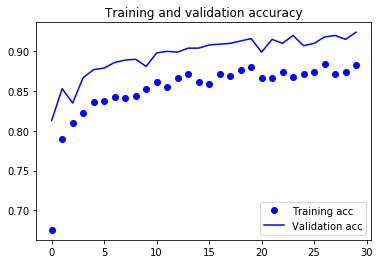

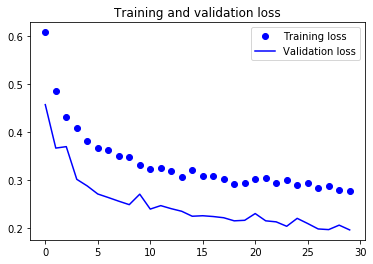

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.3.2

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [17]:
# List 5-22

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 261ms/step - loss: 0.3050 - acc: 0.8590 - val_loss: 0.2216 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2578 - acc: 0.8945 - val_loss: 0.1529 - val_acc: 0.9380
Epoch 3/100
100/100 [==============================] - 23s 234ms/step - loss: 0.2246 - acc: 0.9120 - val_loss: 0.1342 - val_acc: 0.9510
Epoch 4/100
100/100 [==============================] - 25s 248ms/step - loss: 0.2286 - acc: 0.9020 - val_loss: 0.1229 - val_acc: 0.9590
Epoch 5/100
100/100 [==============================] - 26s 260ms/step - loss: 0.2073 - acc: 0.9195 - val_loss: 0.2388 - val_acc: 0.9030
Epoch 6/100
100/100 [==============================] - 27s 271ms/step - loss: 0.2005 - acc: 0.9190 - val_loss: 0.0974 - val_acc: 0.9670
Epoch 7/100
100/100 [==============================] - 24s 244ms/step - loss: 0.2037 - acc: 0.9205 - val_loss: 0.0991 - val_acc: 0.9650
Epoch 8/100
100/100 [===========================

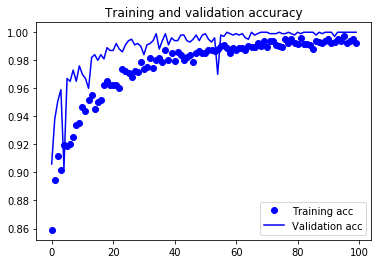

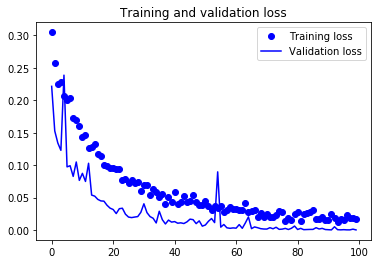

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

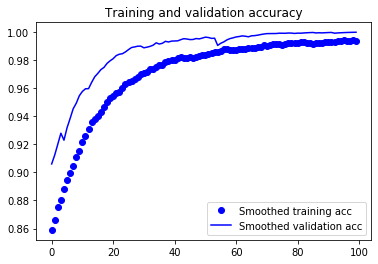

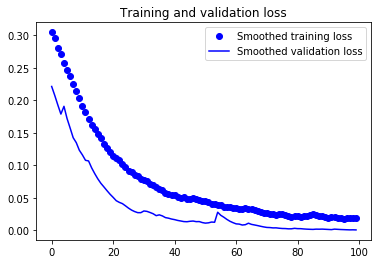

In [20]:
def smooth_curve(points, factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test_acc', test_acc)

Found 1000 images belonging to 2 classes.
test_acc 0.946
